In [1]:
from datetime import datetime, timedelta, date
from itertools import product, chain
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

import numpy as np
import pandas as pd
from constants import *
from pandas_tools import multi_index_add as add
from animated_vaccinations import *
from vaccination import *
import colorsys


In [10]:
daily = raw_vaccination_data(dt='*')[0].set_index('date')[['newPeopleVaccinatedFirstDoseByPublishDate', 'newPeopleVaccinatedSecondDoseByPublishDate', 'newPeopleVaccinatedCompleteByPublishDate']]
daily.dropna(how='all').sort_index()

,newPeopleVaccinatedFirstDoseByPublishDate,newPeopleVaccinatedSecondDoseByPublishDate,newPeopleVaccinatedCompleteByPublishDate
date,,,
2021-01-11,121129.0,19312.0,19312.0
2021-01-11,6182.0,1339.0,1339.0
2021-01-11,12565.0,99.0,99.0
2021-01-11,5200.0,18.0,18.0
2021-01-12,174276.0,13369.0,13369.0
...,...,...,...
2021-03-16,17385.0,16202.0,16202.0
2021-03-17,392769.0,90906.0,90906.0
2021-03-17,5389.0,3256.0,3256.0


In [12]:
def raw_vaccination_data(dt='*'):
    if dt == '*':
        dt = '????-*'
    else:
        dt = pd.to_datetime(dt).date()
    new_weekly_path, new_weekly_dt = find_latest(f'vaccination_{dt}.csv', date_index=-1)
    cum_path, cum_dt = find_latest(f'vaccination_cum_{dt}.csv', date_index=-1)
    assert cum_dt == new_weekly_dt, f'{cum_dt} != {new_weekly_dt}'
    new_weekly_df = read_csv(new_weekly_path)
    cum_df = read_csv(cum_path)
    raw = pd.merge(new_weekly_df, cum_df, how='outer',
                   on=[date_col, area_type, area_code, area_name])
    raw.sort_values([date_col, area_code], inplace=True)
    complete = raw[[complete_dose_daily_cum, second_dose_daily_cum,
                    complete_dose_daily_new, second_dose_daily_new]].dropna(how='any')
    cum_equal = (complete[complete_dose_daily_cum] == complete[second_dose_daily_cum]).all()
    new_equal = ((complete[complete_dose_daily_new] == complete[second_dose_daily_new]).all())
    assert raw[complete_dose_daily_cum].isnull().all() or (cum_equal and new_equal)

    return raw, new_weekly_dt


def weekly_data(raw, nation_codes):
    weekly = raw[[date_col, area_code, first_dose_weekly, second_dose_weekly]].dropna()

    # data massaging:
    initial = pd.DataFrame(
        {date_col: pd.to_datetime(first_vaccination), first_dose_weekly: 0, second_dose_weekly: 0},
        index=nation_codes
    )
    initial.index.name = area_code

    to_fudge = weekly.set_index(date_col).sort_index().loc[:'2020-12-20'].reset_index()
    fudged = to_fudge.groupby(area_code).agg(
        {date_col: 'max', first_dose_weekly: 'sum', second_dose_weekly: 'sum'}
    )

    normal = weekly.set_index(date_col).sort_index().loc['2020-12-21':]
    data = pd.concat((df.reset_index() for df in (initial, fudged, normal)))
    data.rename(columns={first_dose_weekly: 'first_dose', second_dose_weekly: 'second_dose'},
                  errors='raise', inplace=True)
    return data


def daily_data(raw, weekly):
    initial = weekly.groupby(area_code).agg({
        'first_dose': 'sum', 'second_dose': 'sum', date_col: 'max'
    }).reset_index().set_index([date_col, area_code])
    weekly_date = initial.index.max()[0]

    daily_rows = raw[[
        date_col, area_code, first_dose_daily_cum, second_dose_daily_cum
    ]].dropna().set_index([date_col, area_code])
    daily_rows.rename(
        columns={first_dose_daily_cum: 'first_dose', second_dose_daily_cum: 'second_dose'},
        errors='raise', inplace=True
    )

    initial_date = weekly_date + timedelta(days=1)
    initial_from_daily = daily_rows.loc[initial_date]
    initial_from_weekly = initial.loc[weekly_date]
    initial_from_weekly.where(
        initial_from_daily > initial_from_weekly, initial_from_daily, inplace=True
    )

    daily = pd.concat([initial, daily_rows[initial_date:]])

    # If we see drops, then use the latest figure and roll it backwards
    dates = daily.index.levels[0][:-1]
    for d1, d2 in zip(dates, dates.shift(freq='D')):
        d1_data = daily.loc[d1]
        d2_data = daily.loc[d2]
        d1_data[d1_data > d2_data] = d2_data

    return daily.groupby(area_code).diff().dropna().reset_index()


def vaccination_dashboard(savefig=True, show_partial=True):
    # input data:
    raw, data_date = raw_vaccination_data()
    names_frame = raw[[area_code, area_name]].drop_duplicates()
    nation_codes = names_frame[area_code]
    nation_populations = load_population().loc[nation_codes]
    total_population = nation_populations.sum()[0]

    weekly = weekly_data(raw, nation_codes)
    return weekly
    daily = daily_data(raw, weekly)
    all_data = pd.concat([weekly, daily])

    # look out for weirdness
    assert (all_data['first_dose'] >= 0).all()
    assert (all_data['second_dose'] >= 0).all()

    all_data['start'] = all_data[date_col].shift(len(nation_codes))
    all_data['duration'] = all_data[date_col] - all_data['start']
    all_data = all_data.set_index([date_col, area_code])
    all_data['any'] = all_data.groupby(level=-1)['first_dose'].cumsum()
    all_data['full'] = all_data.groupby(level=-1)['second_dose'].cumsum()
    all_data['partial'] = all_data['any'] - all_data['full']
    data = pd.merge(all_data.reset_index(), names_frame, on=area_code)
    max_date = data[date_col].max()

    # data for plotting:
    is_latest_date = data[date_col] == max_date
    latest = data[[area_name, area_code, 'full', 'any', 'partial']][is_latest_date].copy()
    latest = pd.merge(latest, nation_populations, on=area_code)

    latest['full_pct'] = 100 * latest['full'] / latest[population]
    latest['partial_pct'] = 100 * latest['partial'] / latest[population]
    latest['none_pct'] = 100 - latest['full_pct'] - latest['partial_pct']

    pie_data = latest.set_index(area_name).sort_index()
    pie_data = pie_data[['full_pct', 'partial_pct', 'none_pct']].transpose()
    totals = data.pivot_table(values=['partial', 'full'], index=[date_col],
                              columns=area_name).fillna(0)
    totals = totals.swaplevel(axis='columns').sort_index(axis='columns')

    # plotting
    england_col = 0
    ni_col = 6
    scotland_col = 2
    wales_col = 3

    colors = list(chain(*((plt.cm.tab20(i * 2), plt.cm.tab20(i * 2 + (1 if show_partial else 0)))
                          for i in [england_col, ni_col, scotland_col, wales_col])))

    fig = plt.figure(figsize=(16, 9), dpi=100)
    fig.set_facecolor('white')
    fig.suptitle(f'COVID-19 Vaccination Progress in the UK as of {max_date:%d %b %Y}', fontsize=14)

    gs = GridSpec(3, 4, height_ratios=[0.8, 1, 1])
    gs.update(top=0.95, bottom=0.15, right=0.95, left=0.02, wspace=0, hspace=0.2)

    # pie charts:
    for x, nation in enumerate(pie_data):
        ax = plt.subplot(gs[0, x])
        ax.add_patch(plt.Circle((0, 0), radius=1, color='k', fill=False))
        pie_data.plot(ax=ax, y=nation,
                      kind='pie', labels=None, legend=False, startangle=-90, counterclock=False,
                      colors=['green', 'lightgreen', 'white'],
                      )
        pct = pie_data[nation].loc['full_pct'] + pie_data[nation].loc['partial_pct']
        ax.text(0, 0.5, f"{pct:.1f}%", ha='center', va='top', weight='bold', fontsize=14)

    # stack plot for cumulative
    ax = plt.subplot(gs[1, :])
    ax.yaxis.grid(zorder=-10)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_title('UK population partially or fully vaccinated')

    labels = []
    for nation, level in totals.columns:
        if level == 'full':
            labels.append(f"{nation}: {totals[nation].iloc[-1].sum():,.0f} people")
        else:
            labels.append(None)
    ax.stackplot(totals.index, totals.values.transpose(), colors=colors, labels=labels, zorder=10)
    ax.legend(loc='upper left', framealpha=1)

    # make sure the current highest always has a tick:
    current = latest['any'].sum()
    ticks = [t for t in ax.get_yticks() if t <= current]
    if current < ticks[-1] + (ticks[-1] - ticks[-2]) / 2:
        ticks.pop()
    ticks.append(current)
    ax.yaxis.set_major_locator(FixedLocator(ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y / 1_000_000:.1f}m"))

    pct = ax.twinx()
    pct.set_ylim(*(l / total_population for l in ax.get_ylim()))
    pct.yaxis.set_major_locator(FixedLocator([t / total_population for t in ax.get_yticks()]))
    pct.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y * 100:,.0f}%"))

    # bar charts for rates
    ax = plt.subplot(gs[2, :], sharex=ax)
    ax.yaxis.grid(zorder=-10)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y / 1_000_000:.1f}m"))
    ax.set_ylabel('weekly')
    ax.set_xlim(first_vaccination, max_date)
    ax.set_xticks(all_data.index.levels[0], minor=True)
    major_ticks = list(weekly[date_col].unique())
    if max_date > major_ticks[-1] + np.timedelta64(1, 'D'):
        major_ticks.append(max_date.to_datetime64())
    ax.set_xticks(major_ticks)
    ax.xaxis.set_major_formatter(DateFormatter('%d %b'))
    ax.xaxis.label.set_visible(False)
    ax.axvline(weekly[date_col].max(), linestyle='dashed', color='lightgrey', zorder=-10)
    ax.set_title('Rate of injections (weeky by injection date, daily by publish date)')

    bottom = None
    for (nation_name, level), color in zip(totals, colors):
        nation_data = data[data[area_name] == nation_name].iloc[1:].set_index(date_col)
        if bottom is None:
            bottom = pd.Series(0, nation_data.index)
        nation_level_data = nation_data['first_dose' if level == 'partial' else 'second_dose']
        heights = nation_level_data * 7 / nation_data['duration'].dt.days
        ax.bar(
            nation_data.index - nation_data['duration'],
            bottom=bottom,
            height=heights,
            width=nation_data['duration'].dt.days,
            align='edge',
            color=color,
            zorder=10,
        )
        bottom += heights
    ax.yaxis.set_major_locator(MaxNLocator(nbins='auto', steps=[10], prune='lower'))

    daily = ax.twinx()
    daily.set_ylim(*(l / 7 for l in ax.get_ylim()))
    daily.yaxis.set_major_locator(FixedLocator([t / 7 for t in ax.get_yticks()]))
    daily.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y / 1_000_000:.1f}m"))
    daily.set_ylabel('daily')

    fig.text(0.5, 0.08,
             f'@chriswithers13 - '
             f'data from https://coronavirus.data.gov.uk/ retrieved on {data_date:%d %b %Y}',
             ha='center')

    # return latest data so it gets displayed
    if savefig:
        plt.savefig(repo_path / f'vaccination.png', bbox_inches='tight')
    return latest


weekly = vaccination_dashboard()

In [78]:
weekly

,areaCode,date,first_dose,second_dose
0,E92000001,2020-12-08,0.0,0.0
1,N92000002,2020-12-08,0.0,0.0
2,S92000003,2020-12-08,0.0,0.0
3,W92000004,2020-12-08,0.0,0.0
0,E92000001,2020-12-20,574829.0,0.0
1,N92000002,2020-12-20,16068.0,0.0
2,S92000003,2020-12-20,60333.0,0.0
3,W92000004,2020-12-20,24056.0,0.0
0,E92000001,2020-12-27,267809.0,0.0
1,N92000002,2020-12-27,14948.0,0.0


In [79]:
interp = weekly.set_index(['date']).groupby('areaCode')[['first_dose','second_dose']].resample('D').interpolate().reset_index()
interp

,areaCode,date,first_dose,second_dose
0,E92000001,2020-12-08,0.000000,0.000000
1,E92000001,2020-12-09,47902.416667,0.000000
2,E92000001,2020-12-10,95804.833333,0.000000
3,E92000001,2020-12-11,143707.250000,0.000000
4,E92000001,2020-12-12,191609.666667,0.000000
...,...,...,...,...
327,W92000004,2021-02-24,68482.857143,47510.428571
328,W92000004,2021-02-25,66384.142857,50869.571429
329,W92000004,2021-02-26,64285.428571,54228.714286
330,W92000004,2021-02-27,62186.714286,57587.857143


In [89]:
display(interp.set_index(['areaCode', 'date']).loc['E92000001'].sort_index().cumsum())
display(weekly.set_index(['areaCode', 'date']).loc['E92000001'].sort_index().cumsum())

,first_dose,second_dose
date,,
2020-12-08,0.000000e+00,0.0
2020-12-09,4.790242e+04,0.0
2020-12-10,1.437072e+05,0.0
2020-12-11,2.874145e+05,0.0
2020-12-12,4.790242e+05,0.0
...,...,...
2021-02-24,1.063041e+08,3646727.0
2021-02-25,1.084509e+08,3704986.0
2021-02-26,1.106219e+08,3772170.0


,first_dose,second_dose
date,,
2020-12-08,0.0,0.0
2020-12-20,574829.0,0.0
2020-12-27,842638.0,0.0
2021-01-03,1172675.0,20660.0
2021-01-10,2127865.0,407397.0
2021-01-17,3738781.0,448000.0
2021-01-24,5989517.0,454648.0
2021-01-31,8193779.0,463263.0
2021-02-07,10600380.0,472582.0


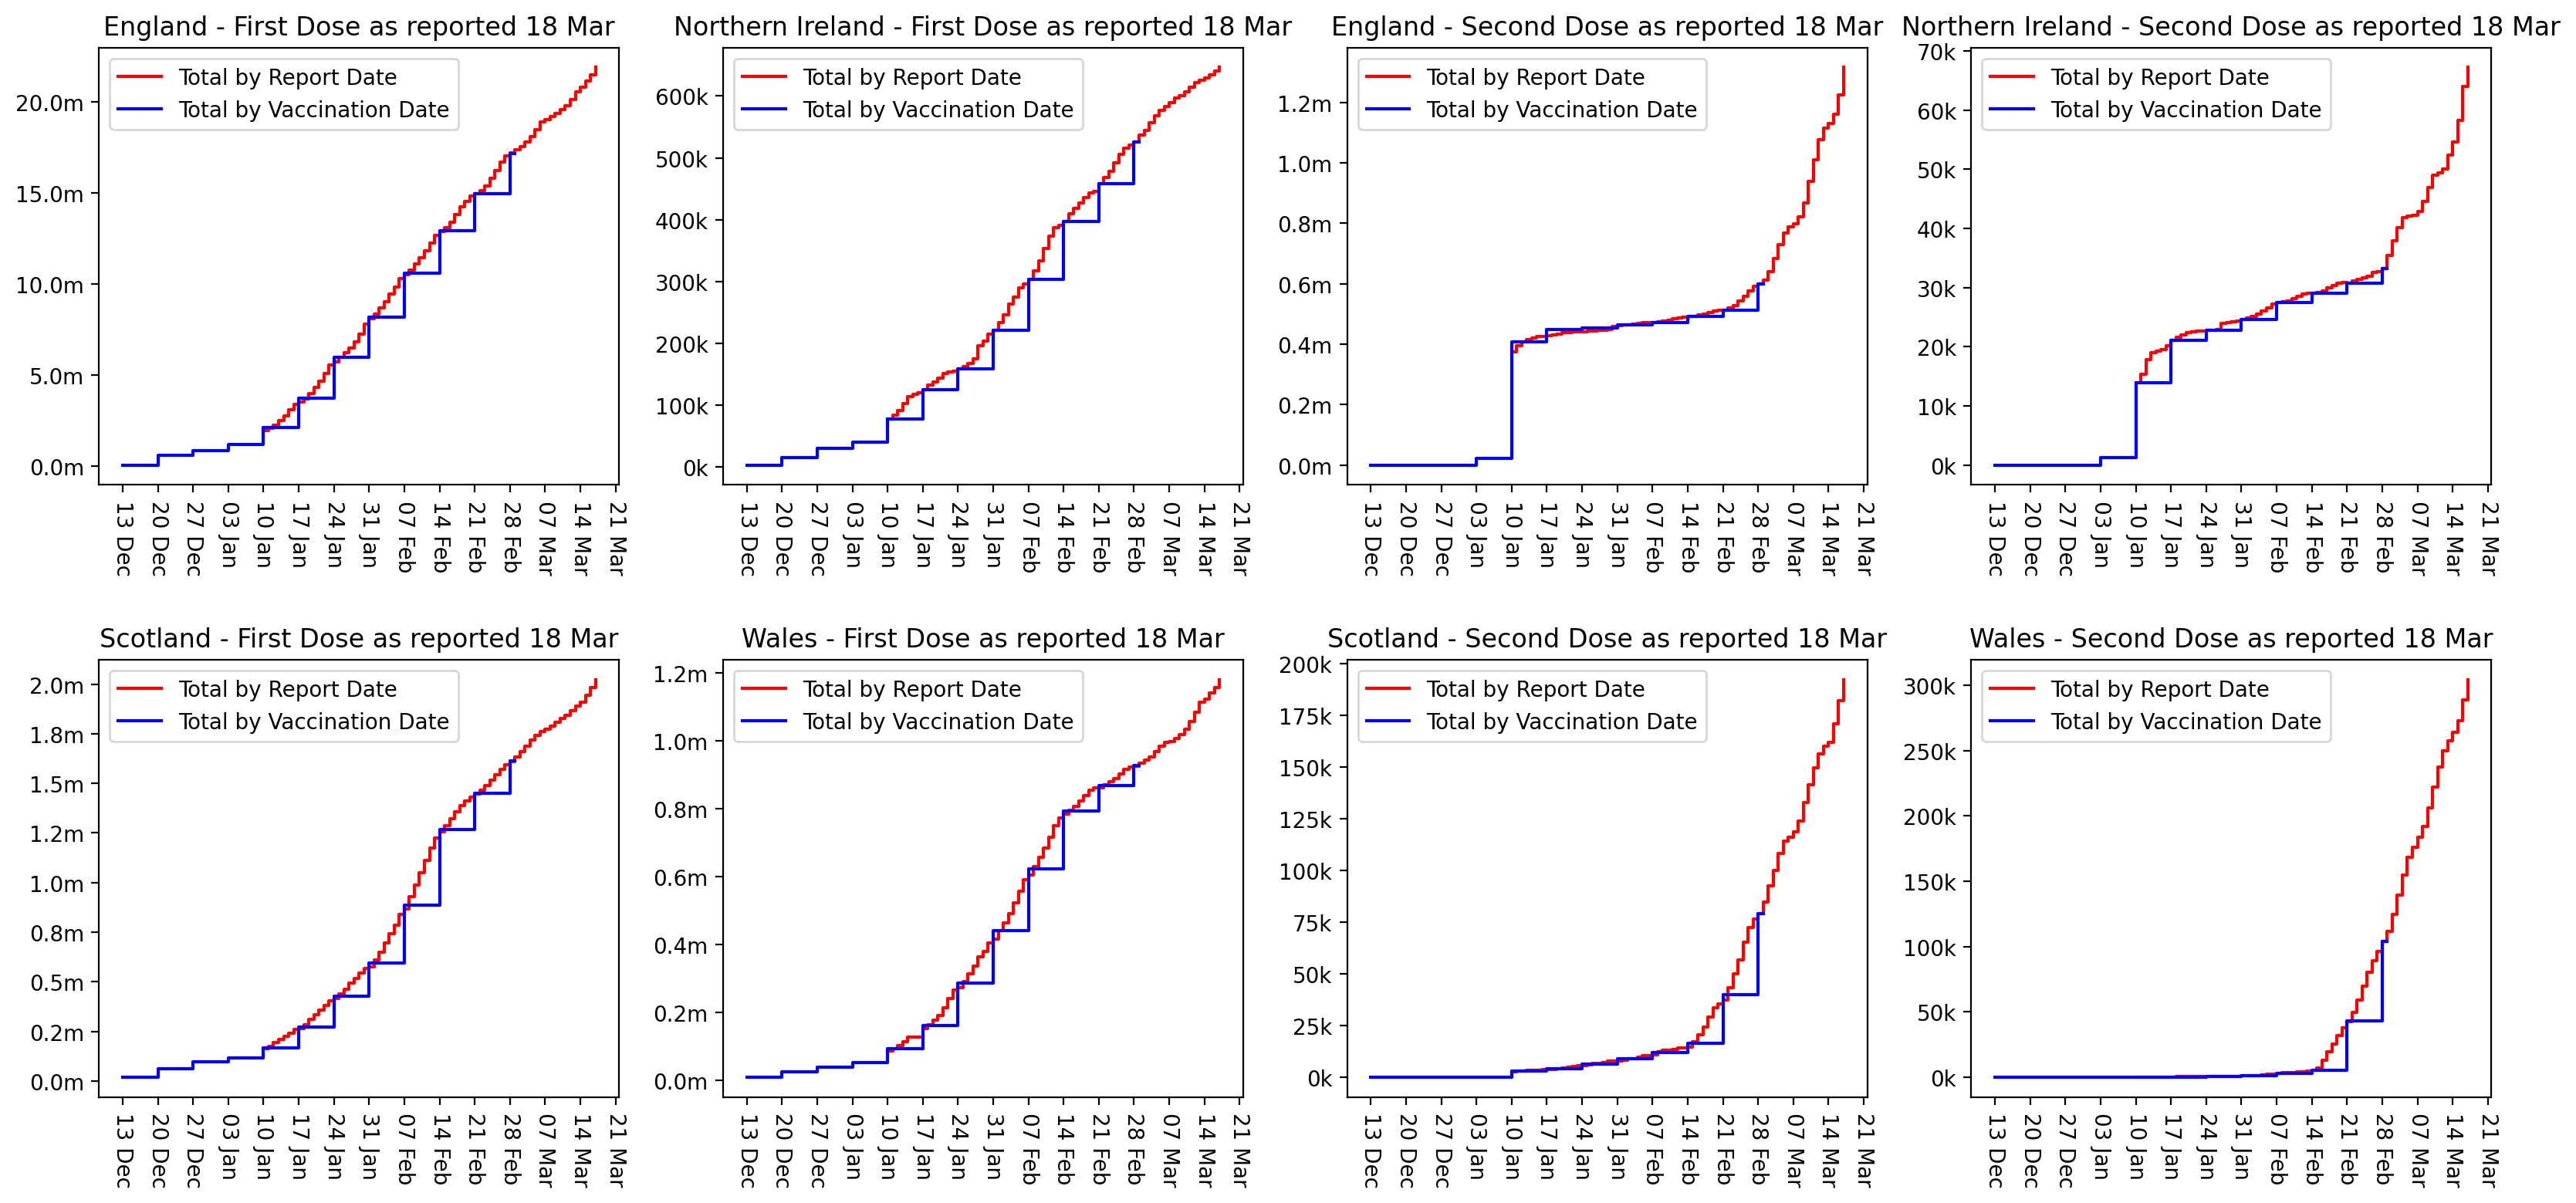

In [2]:
render_plots(selection_mapping()['everything'])

In [3]:
raw, data_date = raw_vaccination_data()
not_complete = ~raw.columns.str.contains('Complete')
by_publish_metrics = raw.columns[raw.columns.str.contains('ByPublishDate') & not_complete]
by_vaccination_metrics = raw.columns[
    raw.columns.str.contains('ByVaccinationDate') & raw.columns.str.startswith('cum') & not_complete
]
metrics = by_publish_metrics.union(by_vaccination_metrics)

In [4]:
pivoted = raw.pivot(index=date_col, columns=area_name, values=metrics)
by_vaccination_index = pivoted[by_vaccination_metrics].dropna(axis='rows', how='all').index
interesting_index = by_vaccination_index.union(by_vaccination_index+timedelta(days=1))
filled = pivoted.fillna(method='ffill')
interesting = filled.loc[filled.index.intersection(interesting_index)].dropna(
    axis='rows', how='all', subset=product(by_publish_metrics, filled.columns.levels[1])
)
add(interesting, 'calc_first', interesting[first_dose_daily_cum] - interesting[first_dose_weekly_cum])
add(interesting, 'calc_second', interesting[second_dose_daily_cum] - interesting[second_dose_weekly_cum])
interesting.columns = interesting.columns.swaplevel()
for area in interesting.columns.levels[0]:
    ordered = interesting[area][[
        first_dose_daily_cum, first_dose_weekly_cum, 'calc_first', first_dose_daily_new,
        second_dose_daily_cum, second_dose_weekly_cum, 'calc_second', second_dose_daily_new,
    ]]
    ordered.index.name=''
    ordered.rename(inplace=True, columns={
        first_dose_daily_cum: '1st Dose (Daily)',
        first_dose_weekly_cum: '1st Dose (Weekly)',
        'calc_first': '+/-',
        first_dose_daily_new: '1st Dose (New)',
        second_dose_daily_cum: '2nd Dose (Daily)',
        second_dose_weekly_cum: '2nd Dose (Weekly)',
        'calc_second': '+/-',
        second_dose_daily_new: '2nd Dose (New)',
    })
    display(f'For {area}:', ordered)

'For England:'

,1st Dose (Daily),1st Dose (Weekly),+/-,1st Dose (New),2nd Dose (Daily),2nd Dose (Weekly),+/-,2nd Dose (New)
,,,,,,,,
2021-01-10,1959151.0,2124665.0,-165514.0,NaN,374613.0,406129.0,-31516.0,NaN
2021-01-11,2080280.0,2124665.0,-44385.0,121129.0,393925.0,406129.0,-12204.0,19312.0
2021-01-17,3520056.0,3732909.0,-212853.0,154564.0,427386.0,446612.0,-19226.0,1284.0
2021-01-18,3687206.0,3732909.0,-45703.0,167150.0,431136.0,446612.0,-15476.0,3750.0
2021-01-24,5727693.0,5977796.0,-250103.0,198592.0,441684.0,453139.0,-11455.0,610.0
2021-01-25,5962544.0,5977796.0,-15252.0,234851.0,443010.0,453139.0,-10129.0,1326.0
2021-01-31,8082355.0,8175910.0,-93555.0,289359.0,460907.0,461605.0,-698.0,2757.0
2021-02-01,8362868.0,8175910.0,186958.0,280513.0,462503.0,461605.0,898.0,1596.0
2021-02-07,10519729.0,10574070.0,-54341.0,229514.0,471636.0,470176.0,1460.0,312.0


'For Northern Ireland:'

,1st Dose (Daily),1st Dose (Weekly),+/-,1st Dose (New),2nd Dose (Daily),2nd Dose (Weekly),+/-,2nd Dose (New)
,,,,,,,,
2021-01-10,78005.0,78005.0,0.0,NaN,13949.0,13949.0,0.0,NaN
2021-01-11,84187.0,78005.0,6182.0,6182.0,15288.0,13949.0,1339.0,1339.0
2021-01-17,125717.0,125717.0,0.0,5330.0,21016.0,21016.0,0.0,842.0
2021-01-18,132857.0,125717.0,7140.0,7140.0,21579.0,21016.0,563.0,563.0
2021-01-24,159642.0,159642.0,0.0,3998.0,22713.0,22713.0,0.0,26.0
2021-01-25,163317.0,159642.0,3675.0,3675.0,22795.0,22713.0,82.0,82.0
2021-01-31,221809.0,221809.0,0.0,7208.0,24612.0,24612.0,0.0,289.0
2021-02-01,233429.0,221809.0,11620.0,11620.0,24882.0,24612.0,270.0,270.0
2021-02-07,303478.0,303478.0,0.0,7563.0,27463.0,27463.0,0.0,256.0


'For Scotland:'

,1st Dose (Daily),1st Dose (Weekly),+/-,1st Dose (New),2nd Dose (Daily),2nd Dose (Weekly),+/-,2nd Dose (New)
,,,,,,,,
2021-01-10,163377.0,167091.0,-3714.0,NaN,2758.0,2868.0,-110.0,NaN
2021-01-11,175942.0,167091.0,8851.0,12565.0,2857.0,2868.0,-11.0,99.0
2021-01-17,264991.0,271569.0,-6578.0,4851.0,3698.0,4004.0,-306.0,41.0
2021-01-18,284582.0,271569.0,13013.0,19591.0,3886.0,4004.0,-118.0,188.0
2021-01-24,415402.0,425134.0,-9732.0,11364.0,5538.0,6087.0,-549.0,155.0
2021-01-25,437900.0,425134.0,12766.0,22498.0,6060.0,6087.0,-27.0,522.0
2021-01-31,575897.0,591910.0,-16013.0,9628.0,7849.0,8613.0,-764.0,55.0
2021-02-01,610778.0,591910.0,18868.0,34881.0,8345.0,8613.0,-268.0,496.0
2021-02-07,866823.0,881205.0,-14382.0,27557.0,10690.0,11734.0,-1044.0,108.0


'For Wales:'

,1st Dose (Daily),1st Dose (Weekly),+/-,1st Dose (New),2nd Dose (Daily),2nd Dose (Weekly),+/-,2nd Dose (New)
,,,,,,,,
2021-01-10,86039.0,91868.0,-5829.0,NaN,79.0,88.0,-9.0,NaN
2021-01-11,91239.0,91868.0,-629.0,5200.0,97.0,88.0,9.0,18.0
2021-01-17,151737.0,159299.0,-7562.0,25362.0,201.0,204.0,-3.0,72.0
2021-01-18,161932.0,159299.0,2633.0,10195.0,265.0,204.0,61.0,64.0
2021-01-24,270833.0,284323.0,-13490.0,6295.0,543.0,602.0,-59.0,27.0
2021-01-25,289566.0,284323.0,5243.0,18733.0,581.0,602.0,-21.0,38.0
2021-01-31,416306.0,436598.0,-20292.0,12843.0,841.0,1002.0,-161.0,55.0
2021-02-01,439640.0,436598.0,3042.0,23334.0,1066.0,1002.0,64.0,225.0
2021-02-07,603976.0,618193.0,-14217.0,14354.0,2792.0,2925.0,-133.0,186.0


In [5]:
for dt in pd.date_range(earliest_vaccination, date.today()-timedelta(days=1)):
    changes = vaccination_changes(dt, exclude_okay=True)
    if changes:
        display(changes)

,,First Dose (Total),Second Dose (Total)
,,,
England,10 Jan 21,"+1,959,151","+374,613"
Northern Ireland,10 Jan 21,"+78,005","+13,949"
Scotland,10 Jan 21,"+163,377","+2,758"
Wales,10 Jan 21,"+86,039",+79


,,First Dose (New),First Dose (Total)
,,,
Northern Ireland,16 Jan 21,"-20,172","-20,172"


,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
Northern Ireland,06 Feb 21,+730,+272,+272,+730,+272,+272


,,Second Dose (New),Complete (New)
,,,
Northern Ireland,21 Feb 21,-11,-11
